In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
import scipy.stats as stats
import scipy.optimize as spo
from scipy.optimize import minimize
from helpers_similarity import *
from helpers_optimization import *

In [16]:
# standard deviation of spherical Gaussian distribution
mu = 0.0 
sigma_u = 1.0
sigma_v = 1.0
sigma = 0.2#[0, 0.2, 0.4, 0.6, 0.8, 1] 

D = 2 #dimension
N_vals = [10, 20, 30]
M_vals = [10, 20, 30]
nb_iter = 100 #1000

optimize the objective function by minimizing it w.r.t U and V respectively 

In [17]:
def optimization_fn(M,N):
    U, V, R = generate_U_V_R(mu, sigma_u, sigma_v, sigma, D, N, M)

    U0 = np.random.normal(mu, sigma_u, D*N) 
    V0 = np.random.normal(mu, sigma_v, D*M)
    U_res = minimize(objective_function_U, U0, args=(R, V, sigma_u, sigma_v, sigma, D, N))
    V_res = minimize(objective_function_V, V0, args=(R, U, sigma_u, sigma_v, sigma, D, M))

    U_result = 0
    if U_res.success :
        U_result = U_res.x.reshape((D, N))
    else :
        print('No minimum found for U')
        U_result = np.zeros((D, N))
    diff_norm_U = frob(U, U_result)
    
    V_result = 0
    if V_res.success :
        V_result = V_res.x.reshape((D, M))
    else :
        print('No minimum found for V')
        V_result = np.zeros((D, M))
    diff_norm_V = frob(V, V_result)
    
    return diff_norm_U, diff_norm_V


compute average Difference (in Frobenius/ Procrustes norm) of U, U_result and V, V_result for different values of M

In [18]:
def norm_results(M,N):
    avg_U = 0
    avg_V = 0
    for i in range(nb_iter):
        diff_U, diff_V = optimization_fn(M,N)
        avg_U += diff_U
        avg_V += diff_V
    avg_U = avg_U/nb_iter
    avg_V = avg_V/nb_iter
    return avg_U, avg_V

In [19]:
data = []
for i in range(len(N_vals)):
    for j in range(len(M_vals)):
        print(i,j)
        avg_U, avg_V = norm_results(M_vals[j], N_vals[i])
        row= [N_vals[i], M_vals[j], avg_U, avg_V]
        data.append(row)


0 0
0 1
0 2
1 0
1 1
1 2
2 0
2 1
2 2


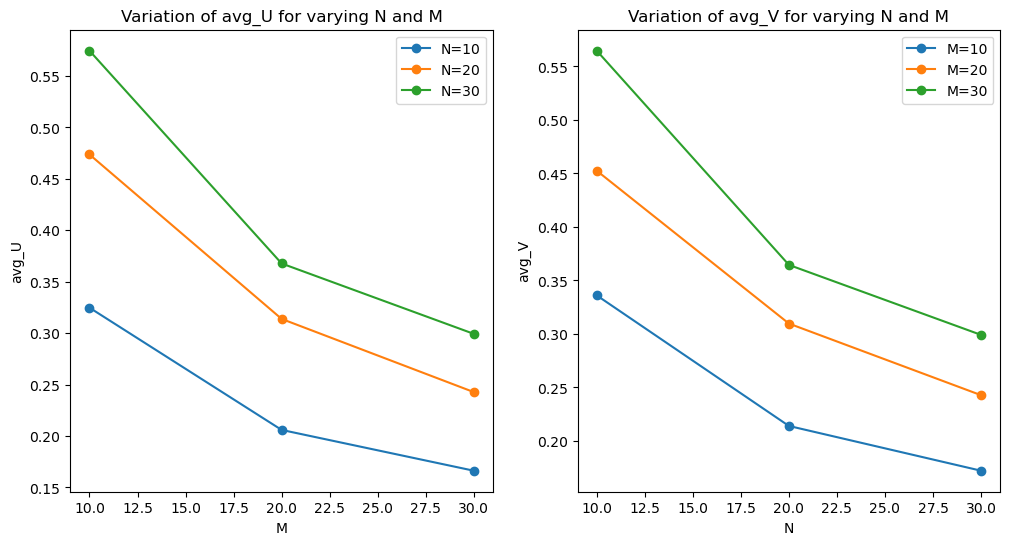

In [20]:
df = pd.DataFrame(data, columns = ['N', 'M', 'avg_U', 'avg_V'])
#df.to_csv('results_optimization.csv')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
# plot as a function of M for avg_U and as a function of N fro avg_V
for n in df['N'].unique():
    df_m = df[df['N'] == n]
    ax1.plot(df_m['M'], df_m['avg_U'], marker='o', label=f'N={n}')
for m in df['M'].unique():
    df_n = df[df['M'] == m]
    ax2.plot(df_n['N'], df_n['avg_V'], marker='o', label=f'M={m}')

ax1.set_xlabel('M')
ax1.set_ylabel('avg_U')
ax1.set_title('Variation of avg_U for varying N and M')
ax1.legend()

ax2.set_xlabel('N')
ax2.set_ylabel('avg_V')
ax2.set_title('Variation of avg_V for varying N and M')
ax2.legend()

plt.show()

In [21]:
fig.savefig('avg_U_V.png')
